In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

In [2]:
import copy, math

In [3]:
import plotly.express as px

In [4]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [5]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
#import plotly.graph_objects as go
init_notebook_mode(connected=True)

In [6]:
def format_comma(num):
    return f'{num:,.0f}'

# Setup

## Define all keys

In [7]:
state_key = {
'EC':'Eastern Cape',
'FS':'Free State',
'GP':'Gauteng',
'KZN':'Kwazulu Natal',
'LP':'Limpopo',
'MP':'Mpumalanga',
'NC':'Northern Cape',
'NW':'North-West',
'WC':'Western Cape'
}
state_filter = list(state_key.keys())
state_filter

['EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']

In [8]:
state_labels = list(state_key.values())
state_labels

['Eastern Cape',
 'Free State',
 'Gauteng',
 'Kwazulu Natal',
 'Limpopo',
 'Mpumalanga',
 'Northern Cape',
 'North-West',
 'Western Cape']

In [9]:
#not required
state_filter_d = copy.deepcopy(state_filter)
state_filter_d.append('Date')
state_filter_d

['EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC', 'Date']

In [10]:
state_filter_t = copy.deepcopy(state_filter)
state_filter_t.insert(0,'Total RSA')
state_filter_t

['Total RSA', 'EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']

In [11]:
state_filter_all = copy.deepcopy(state_filter)
state_filter_all.insert(0,'Total RSA')
state_filter_all.append('Date')
state_filter_all

['Total RSA', 'EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC', 'Date']

## Download SA population stats

In [12]:
# Mid-year 2019 Estimates
# https://www.statssa.gov.za/publications/P0302/P03022019.pdf
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/district_data/za_province_pop.csv'
province_pops = pd.read_csv(url, header=None, names=['Province','Pop'])
province_pops

Province       Pop
0        Gauteng  15176115
1  KwaZulu-Natal  11289086
2   Western Cape   6844272
3   Eastern Cape   6712276
4        Limpopo   5982584
5     Mpumalanga   4592187
6      Northwest   4027160
7     Free State   2887465
8  Northern Cape   1263875

In [13]:
country_pop = province_pops['Pop'].sum()
country_pop

58775020

In [14]:
province_pops.iloc[0]['Pop']

15176115

In [15]:
state_pop = {
    'EC': 6712276,
    'FS': 2887465,
    'GP': 15176115,
    'KZN': 11289086,
    'LP': 5982584,
    'MP': 4592187,
    'NC': 1263875,
    'NW': 4027160,
    'WC': 6844272
}

# Download Data

## Download case data

In [16]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv'
states_cases_i = pd.read_csv(url, parse_dates=['date'], dayfirst=True, squeeze=True, index_col=0)
states_cases_i

YYYYMMDD       EC       FS        GP       KZN       LP       MP  \
date                                                                           
2020-03-05  20200305      0.0      0.0       0.0       1.0      0.0      0.0   
2020-03-07  20200307      0.0      0.0       1.0       1.0      0.0      0.0   
2020-03-08  20200308      0.0      0.0       1.0       2.0      0.0      0.0   
2020-03-09  20200309      0.0      0.0       1.0       6.0      0.0      0.0   
2020-03-11  20200311      0.0      0.0       5.0       7.0      0.0      0.0   
...              ...      ...      ...       ...       ...      ...      ...   
2020-09-14  20200914  87456.0  42120.0  215307.0  116513.0  14216.0  25825.0   
2020-09-15  20200915  87513.0  42255.0  215481.0  116674.0  14263.0  25860.0   
2020-09-16  20200916  87663.0  42602.0  215898.0  116910.0  14364.0  25986.0   
2020-09-17  20200917  87776.0  43041.0  216341.0  117147.0  14444.0  26104.0   
2020-09-18  20200918  87894.0  43375.0  216790.0  117360.0  14557.0  26262.0   

                 NC       NW        WC  UNKNOWN   total  \
date                                                      
2020-03-05      0.0      0.0       0.0      0.0       1   
2020-03-07      0.0      0.0       0.0      0.0       2   
2020-03-08      0.0      0.0       0.0      0.0       3   
2020-03-09      0.0      0.0       0.0      0.0       7   
2020-03-11      0.0      0.0       1.0      0.0      13   
...             ...      ...       ...      ...     ...   
2020-09-14  13564.0  27262.0  108486.0      0.0  650749   
2020-09-15  13616.0  27321.0  108538.0      0.0  651521   
2020-09-16  13727.0  27527.0  108767.0      0.0  653444   
2020-09-17  14003.0  27721.0  108995.0      0.0  655572   
2020-09-18  14376.0  27856.0  109157.0      0.0  657627   

                                                       source  
date                                                           
2020-03-05                                                NaN  
2020-03-07                                                NaN  
2020-03-08                                                NaN  
2020-03-09                                                NaN  
2020-03-11                                                NaN  
...                                                       ...  
2020-09-14  https://twitter.com/nicd_sa/status/13056147254...  
2020-09-15  https://twitter.com/nicd_sa/status/13059618189...  
2020-09-16  https://twitter.com/nicd_sa/status/13063054181...  
2020-09-17  https://sacoronavirus.co.za/2020/09/17/update-...  
2020-09-18  https://sacoronavirus.co.za/2020/09/18/update-...  

[196 rows x 13 columns]

In [17]:
casezero = states_cases_i.index[0]
caselast = states_cases_i.index[-1]
casezero, caselast

(Timestamp('2020-03-05 00:00:00'), Timestamp('2020-09-18 00:00:00'))

In [18]:
idx = pd.date_range(casezero, caselast)
idx

DatetimeIndex(['2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
               '2020-03-13', '2020-03-14',
               ...
               '2020-09-09', '2020-09-10', '2020-09-11', '2020-09-12',
               '2020-09-13', '2020-09-14', '2020-09-15', '2020-09-16',
               '2020-09-17', '2020-09-18'],
              dtype='datetime64[ns]', length=198, freq='D')

In [19]:
states_cases_i = states_cases_i.reindex(idx, method='ffill')
states_cases_i = states_cases_i.rename(columns={'total':'Total RSA'})
states_cases_i

YYYYMMDD       EC       FS        GP       KZN       LP       MP  \
2020-03-05  20200305      0.0      0.0       0.0       1.0      0.0      0.0   
2020-03-06  20200305      0.0      0.0       0.0       1.0      0.0      0.0   
2020-03-07  20200307      0.0      0.0       1.0       1.0      0.0      0.0   
2020-03-08  20200308      0.0      0.0       1.0       2.0      0.0      0.0   
2020-03-09  20200309      0.0      0.0       1.0       6.0      0.0      0.0   
...              ...      ...      ...       ...       ...      ...      ...   
2020-09-14  20200914  87456.0  42120.0  215307.0  116513.0  14216.0  25825.0   
2020-09-15  20200915  87513.0  42255.0  215481.0  116674.0  14263.0  25860.0   
2020-09-16  20200916  87663.0  42602.0  215898.0  116910.0  14364.0  25986.0   
2020-09-17  20200917  87776.0  43041.0  216341.0  117147.0  14444.0  26104.0   
2020-09-18  20200918  87894.0  43375.0  216790.0  117360.0  14557.0  26262.0   

                 NC       NW        WC  UNKNOWN  Total RSA  \
2020-03-05      0.0      0.0       0.0      0.0          1   
2020-03-06      0.0      0.0       0.0      0.0          1   
2020-03-07      0.0      0.0       0.0      0.0          2   
2020-03-08      0.0      0.0       0.0      0.0          3   
2020-03-09      0.0      0.0       0.0      0.0          7   
...             ...      ...       ...      ...        ...   
2020-09-14  13564.0  27262.0  108486.0      0.0     650749   
2020-09-15  13616.0  27321.0  108538.0      0.0     651521   
2020-09-16  13727.0  27527.0  108767.0      0.0     653444   
2020-09-17  14003.0  27721.0  108995.0      0.0     655572   
2020-09-18  14376.0  27856.0  109157.0      0.0     657627   

                                                       source  
2020-03-05                                                NaN  
2020-03-06                                                NaN  
2020-03-07                                                NaN  
2020-03-08                                                NaN  
2020-03-09                                                NaN  
...                                                       ...  
2020-09-14  https://twitter.com/nicd_sa/status/13056147254...  
2020-09-15  https://twitter.com/nicd_sa/status/13059618189...  
2020-09-16  https://twitter.com/nicd_sa/status/13063054181...  
2020-09-17  https://sacoronavirus.co.za/2020/09/17/update-...  
2020-09-18  https://sacoronavirus.co.za/2020/09/18/update-...  

[198 rows x 13 columns]

In [20]:
states_cases = states_cases_i.copy()
states_cases = states_cases.reset_index()
states_cases = states_cases.rename(columns={'index':'Date'})
states_cases

Date  YYYYMMDD       EC       FS        GP       KZN       LP  \
0   2020-03-05  20200305      0.0      0.0       0.0       1.0      0.0   
1   2020-03-06  20200305      0.0      0.0       0.0       1.0      0.0   
2   2020-03-07  20200307      0.0      0.0       1.0       1.0      0.0   
3   2020-03-08  20200308      0.0      0.0       1.0       2.0      0.0   
4   2020-03-09  20200309      0.0      0.0       1.0       6.0      0.0   
..         ...       ...      ...      ...       ...       ...      ...   
193 2020-09-14  20200914  87456.0  42120.0  215307.0  116513.0  14216.0   
194 2020-09-15  20200915  87513.0  42255.0  215481.0  116674.0  14263.0   
195 2020-09-16  20200916  87663.0  42602.0  215898.0  116910.0  14364.0   
196 2020-09-17  20200917  87776.0  43041.0  216341.0  117147.0  14444.0   
197 2020-09-18  20200918  87894.0  43375.0  216790.0  117360.0  14557.0   

          MP       NC       NW        WC  UNKNOWN  Total RSA  \
0        0.0      0.0      0.0       0.0      0.0          1   
1        0.0      0.0      0.0       0.0      0.0          1   
2        0.0      0.0      0.0       0.0      0.0          2   
3        0.0      0.0      0.0       0.0      0.0          3   
4        0.0      0.0      0.0       0.0      0.0          7   
..       ...      ...      ...       ...      ...        ...   
193  25825.0  13564.0  27262.0  108486.0      0.0     650749   
194  25860.0  13616.0  27321.0  108538.0      0.0     651521   
195  25986.0  13727.0  27527.0  108767.0      0.0     653444   
196  26104.0  14003.0  27721.0  108995.0      0.0     655572   
197  26262.0  14376.0  27856.0  109157.0      0.0     657627   

                                                source  
0                                                  NaN  
1                                                  NaN  
2                                                  NaN  
3                                                  NaN  
4                                                  NaN  
..                                                 ...  
193  https://twitter.com/nicd_sa/status/13056147254...  
194  https://twitter.com/nicd_sa/status/13059618189...  
195  https://twitter.com/nicd_sa/status/13063054181...  
196  https://sacoronavirus.co.za/2020/09/17/update-...  
197  https://sacoronavirus.co.za/2020/09/18/update-...  

[198 rows x 14 columns]

## Download death data

In [21]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_deaths.csv'
states_deaths_i = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True,index_col=0).sort_index()
states_deaths_i

YYYYMMDD    EC   FS    GP   KZN   LP   MP   NC   NW    WC  \
date                                                                    
2020-03-27  20200327     0    0     0     0    0    0    0    0     1   
2020-03-28  20200328     0    0     0     1    0    0    0    0     1   
2020-03-30  20200330     0    1     0     1    0    0    0    0     1   
2020-03-31  20200331     0    1     1     2    0    0    0    0     1   
2020-04-03  20200403     0    1     1     6    0    0    0    0     1   
...              ...   ...  ...   ...   ...  ...  ...  ...  ...   ...   
2020-09-14  20200914  3051  838  3921  2409  258  466  165  325  4066   
2020-09-15  20200915  3055  838  3933  2425  325  485  176  325  4079   
2020-09-16  20200916  3055  838  3947  2449  325  496  182  325  4088   
2020-09-17  20200917  3058  838  3960  2469  344  496  182  325  4100   
2020-09-18  20200918  3063  838  4022  2478  344  496  184  325  4107   

            UNKNOWN  total                                             source  
date                                                                           
2020-03-27        0      1  https://sacoronavirus.co.za/2020/03/27/latest-...  
2020-03-28        0      2                                                NaN  
2020-03-30        0      3                                                NaN  
2020-03-31        0      5                                                NaN  
2020-04-03        0      9                                                NaN  
...             ...    ...                                                ...  
2020-09-14        0  15499  https://twitter.com/nicd_sa/status/13056147254...  
2020-09-15        0  15641  https://twitter.com/nicd_sa/status/13059618189...  
2020-09-16        0  15705  https://twitter.com/nicd_sa/status/13063054181...  
2020-09-17        0  15772  https://sacoronavirus.co.za/2020/09/17/update-...  
2020-09-18        0  15857  https://sacoronavirus.co.za/2020/09/18/update-...  

[172 rows x 13 columns]

In [22]:
states_deaths_i = states_deaths_i.reindex(idx, method='ffill')
states_deaths_i

YYYYMMDD      EC     FS      GP     KZN     LP     MP     NC  \
2020-03-05         NaN     NaN    NaN     NaN     NaN    NaN    NaN    NaN   
2020-03-06         NaN     NaN    NaN     NaN     NaN    NaN    NaN    NaN   
2020-03-07         NaN     NaN    NaN     NaN     NaN    NaN    NaN    NaN   
2020-03-08         NaN     NaN    NaN     NaN     NaN    NaN    NaN    NaN   
2020-03-09         NaN     NaN    NaN     NaN     NaN    NaN    NaN    NaN   
...                ...     ...    ...     ...     ...    ...    ...    ...   
2020-09-14  20200914.0  3051.0  838.0  3921.0  2409.0  258.0  466.0  165.0   
2020-09-15  20200915.0  3055.0  838.0  3933.0  2425.0  325.0  485.0  176.0   
2020-09-16  20200916.0  3055.0  838.0  3947.0  2449.0  325.0  496.0  182.0   
2020-09-17  20200917.0  3058.0  838.0  3960.0  2469.0  344.0  496.0  182.0   
2020-09-18  20200918.0  3063.0  838.0  4022.0  2478.0  344.0  496.0  184.0   

               NW      WC  UNKNOWN    total  \
2020-03-05    NaN     NaN      NaN      NaN   
2020-03-06    NaN     NaN      NaN      NaN   
2020-03-07    NaN     NaN      NaN      NaN   
2020-03-08    NaN     NaN      NaN      NaN   
2020-03-09    NaN     NaN      NaN      NaN   
...           ...     ...      ...      ...   
2020-09-14  325.0  4066.0      0.0  15499.0   
2020-09-15  325.0  4079.0      0.0  15641.0   
2020-09-16  325.0  4088.0      0.0  15705.0   
2020-09-17  325.0  4100.0      0.0  15772.0   
2020-09-18  325.0  4107.0      0.0  15857.0   

                                                       source  
2020-03-05                                                NaN  
2020-03-06                                                NaN  
2020-03-07                                                NaN  
2020-03-08                                                NaN  
2020-03-09                                                NaN  
...                                                       ...  
2020-09-14  https://twitter.com/nicd_sa/status/13056147254...  
2020-09-15  https://twitter.com/nicd_sa/status/13059618189...  
2020-09-16  https://twitter.com/nicd_sa/status/13063054181...  
2020-09-17  https://sacoronavirus.co.za/2020/09/17/update-...  
2020-09-18  https://sacoronavirus.co.za/2020/09/18/update-...  

[198 rows x 13 columns]

In [23]:
states_deaths_i.iloc[0, :] = states_deaths_i.iloc[0, :].replace({np.nan:0})
states_deaths_i = states_deaths_i.ffill(axis=0)
states_deaths_i = states_deaths_i.rename(columns={'total':'Total RSA'})
states_deaths_i

YYYYMMDD      EC     FS      GP     KZN     LP     MP     NC  \
2020-03-05         0.0     0.0    0.0     0.0     0.0    0.0    0.0    0.0   
2020-03-06         0.0     0.0    0.0     0.0     0.0    0.0    0.0    0.0   
2020-03-07         0.0     0.0    0.0     0.0     0.0    0.0    0.0    0.0   
2020-03-08         0.0     0.0    0.0     0.0     0.0    0.0    0.0    0.0   
2020-03-09         0.0     0.0    0.0     0.0     0.0    0.0    0.0    0.0   
...                ...     ...    ...     ...     ...    ...    ...    ...   
2020-09-14  20200914.0  3051.0  838.0  3921.0  2409.0  258.0  466.0  165.0   
2020-09-15  20200915.0  3055.0  838.0  3933.0  2425.0  325.0  485.0  176.0   
2020-09-16  20200916.0  3055.0  838.0  3947.0  2449.0  325.0  496.0  182.0   
2020-09-17  20200917.0  3058.0  838.0  3960.0  2469.0  344.0  496.0  182.0   
2020-09-18  20200918.0  3063.0  838.0  4022.0  2478.0  344.0  496.0  184.0   

               NW      WC  UNKNOWN  Total RSA  \
2020-03-05    0.0     0.0      0.0        0.0   
2020-03-06    0.0     0.0      0.0        0.0   
2020-03-07    0.0     0.0      0.0        0.0   
2020-03-08    0.0     0.0      0.0        0.0   
2020-03-09    0.0     0.0      0.0        0.0   
...           ...     ...      ...        ...   
2020-09-14  325.0  4066.0      0.0    15499.0   
2020-09-15  325.0  4079.0      0.0    15641.0   
2020-09-16  325.0  4088.0      0.0    15705.0   
2020-09-17  325.0  4100.0      0.0    15772.0   
2020-09-18  325.0  4107.0      0.0    15857.0   

                                                       source  
2020-03-05                                                  0  
2020-03-06                                                  0  
2020-03-07                                                  0  
2020-03-08                                                  0  
2020-03-09                                                  0  
...                                                       ...  
2020-09-14  https://twitter.com/nicd_sa/status/13056147254...  
2020-09-15  https://twitter.com/nicd_sa/status/13059618189...  
2020-09-16  https://twitter.com/nicd_sa/status/13063054181...  
2020-09-17  https://sacoronavirus.co.za/2020/09/17/update-...  
2020-09-18  https://sacoronavirus.co.za/2020/09/18/update-...  

[198 rows x 13 columns]

In [24]:
states_deaths = states_deaths_i.copy()
states_deaths = states_deaths.reset_index()
states_deaths = states_deaths.rename(columns={'index':'Date'})
states_deaths

Date    YYYYMMDD      EC     FS      GP     KZN     LP     MP  \
0   2020-03-05         0.0     0.0    0.0     0.0     0.0    0.0    0.0   
1   2020-03-06         0.0     0.0    0.0     0.0     0.0    0.0    0.0   
2   2020-03-07         0.0     0.0    0.0     0.0     0.0    0.0    0.0   
3   2020-03-08         0.0     0.0    0.0     0.0     0.0    0.0    0.0   
4   2020-03-09         0.0     0.0    0.0     0.0     0.0    0.0    0.0   
..         ...         ...     ...    ...     ...     ...    ...    ...   
193 2020-09-14  20200914.0  3051.0  838.0  3921.0  2409.0  258.0  466.0   
194 2020-09-15  20200915.0  3055.0  838.0  3933.0  2425.0  325.0  485.0   
195 2020-09-16  20200916.0  3055.0  838.0  3947.0  2449.0  325.0  496.0   
196 2020-09-17  20200917.0  3058.0  838.0  3960.0  2469.0  344.0  496.0   
197 2020-09-18  20200918.0  3063.0  838.0  4022.0  2478.0  344.0  496.0   

        NC     NW      WC  UNKNOWN  Total RSA  \
0      0.0    0.0     0.0      0.0        0.0   
1      0.0    0.0     0.0      0.0        0.0   
2      0.0    0.0     0.0      0.0        0.0   
3      0.0    0.0     0.0      0.0        0.0   
4      0.0    0.0     0.0      0.0        0.0   
..     ...    ...     ...      ...        ...   
193  165.0  325.0  4066.0      0.0    15499.0   
194  176.0  325.0  4079.0      0.0    15641.0   
195  182.0  325.0  4088.0      0.0    15705.0   
196  182.0  325.0  4100.0      0.0    15772.0   
197  184.0  325.0  4107.0      0.0    15857.0   

                                                source  
0                                                    0  
1                                                    0  
2                                                    0  
3                                                    0  
4                                                    0  
..                                                 ...  
193  https://twitter.com/nicd_sa/status/13056147254...  
194  https://twitter.com/nicd_sa/status/13059618189...  
195  https://twitter.com/nicd_sa/status/13063054181...  
196  https://sacoronavirus.co.za/2020/09/17/update-...  
197  https://sacoronavirus.co.za/2020/09/18/update-...  

[198 rows x 14 columns]

## Download recovery data

In [25]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_recoveries.csv'
states_recovery_i = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True,index_col=0).sort_index()
states_recovery_i

YYYYMMDD     EC     FS      GP     KZN     LP     MP     NC  \
date                                                                      
2020-04-17  20200417      9     71     479      96     18      9     10   
2020-04-18  20200418      9     71     479      96     18      9     10   
2020-04-19  20200419      9     71     479      96     18      9     10   
2020-04-20  20200420     15     74     545     151     21     14     13   
2020-04-21  20200421     15     74     545     151     21     14     13   
...              ...    ...    ...     ...     ...    ...    ...    ...   
2020-09-14  20200914  82842  27678  191198  106540  13313  24469  10256   
2020-09-15  20200915  83629  28452  191668  107149  13413  24597  10412   
2020-09-16  20200916  83629  28586  191923  107282  13413  24653  10486   
2020-09-17  20200917  83629  28759  192081  107732  13511  24675  10516   
2020-09-18  20200918  83629  28934  192447  107777  13572  24813  10640   

               NW      WC  UNKNOWN   total  \
date                                         
2020-04-17      6     205        0     903   
2020-04-18      6     205        0     903   
2020-04-19      6     205        0     903   
2020-04-20      6     216        0    1055   
2020-04-21      6     216        0    1055   
...           ...     ...      ...     ...   
2020-09-14  22214  100779        0  579289   
2020-09-15  22762  101044        0  583126   
2020-09-16  22948  101275        0  584195   
2020-09-17  22948  101452        0  585303   
2020-09-18  23382  101650        0  586844   

                                                       source  
date                                                           
2020-04-17  https://twitter.com/nicd_sa/status/12512151947...  
2020-04-18  https://twitter.com/nicd_sa/status/12515952235...  
2020-04-19  https://twitter.com/nicd_sa/status/12519270552...  
2020-04-20  https://twitter.com/nicd_sa/status/12523098244...  
2020-04-21  https://twitter.com/nicd_sa/status/12526435556...  
...                                                       ...  
2020-09-14  https://twitter.com/nicd_sa/status/13056147254...  
2020-09-15  https://twitter.com/nicd_sa/status/13059618189...  
2020-09-16  https://twitter.com/nicd_sa/status/13063054181...  
2020-09-17  https://sacoronavirus.co.za/2020/09/17/update-...  
2020-09-18  https://sacoronavirus.co.za/2020/09/18/update-...  

[149 rows x 13 columns]

In [26]:
states_recovery_i = states_recovery_i.reindex(idx, method='ffill')
states_recovery_i

YYYYMMDD       EC       FS        GP       KZN       LP  \
2020-03-05         NaN      NaN      NaN       NaN       NaN      NaN   
2020-03-06         NaN      NaN      NaN       NaN       NaN      NaN   
2020-03-07         NaN      NaN      NaN       NaN       NaN      NaN   
2020-03-08         NaN      NaN      NaN       NaN       NaN      NaN   
2020-03-09         NaN      NaN      NaN       NaN       NaN      NaN   
...                ...      ...      ...       ...       ...      ...   
2020-09-14  20200914.0  82842.0  27678.0  191198.0  106540.0  13313.0   
2020-09-15  20200915.0  83629.0  28452.0  191668.0  107149.0  13413.0   
2020-09-16  20200916.0  83629.0  28586.0  191923.0  107282.0  13413.0   
2020-09-17  20200917.0  83629.0  28759.0  192081.0  107732.0  13511.0   
2020-09-18  20200918.0  83629.0  28934.0  192447.0  107777.0  13572.0   

                 MP       NC       NW        WC  UNKNOWN     total  \
2020-03-05      NaN      NaN      NaN       NaN      NaN       NaN   
2020-03-06      NaN      NaN      NaN       NaN      NaN       NaN   
2020-03-07      NaN      NaN      NaN       NaN      NaN       NaN   
2020-03-08      NaN      NaN      NaN       NaN      NaN       NaN   
2020-03-09      NaN      NaN      NaN       NaN      NaN       NaN   
...             ...      ...      ...       ...      ...       ...   
2020-09-14  24469.0  10256.0  22214.0  100779.0      0.0  579289.0   
2020-09-15  24597.0  10412.0  22762.0  101044.0      0.0  583126.0   
2020-09-16  24653.0  10486.0  22948.0  101275.0      0.0  584195.0   
2020-09-17  24675.0  10516.0  22948.0  101452.0      0.0  585303.0   
2020-09-18  24813.0  10640.0  23382.0  101650.0      0.0  586844.0   

                                                       source  
2020-03-05                                                NaN  
2020-03-06                                                NaN  
2020-03-07                                                NaN  
2020-03-08                                                NaN  
2020-03-09                                                NaN  
...                                                       ...  
2020-09-14  https://twitter.com/nicd_sa/status/13056147254...  
2020-09-15  https://twitter.com/nicd_sa/status/13059618189...  
2020-09-16  https://twitter.com/nicd_sa/status/13063054181...  
2020-09-17  https://sacoronavirus.co.za/2020/09/17/update-...  
2020-09-18  https://sacoronavirus.co.za/2020/09/18/update-...  

[198 rows x 13 columns]

In [27]:
states_recovery_i.iloc[0, :] = states_recovery_i.iloc[0, :].replace({np.nan:0})
states_recovery_i = states_recovery_i.ffill(axis=0)
states_recovery_i = states_recovery_i.rename(columns={'total':'Total RSA'})
states_recovery_i

YYYYMMDD       EC       FS        GP       KZN       LP  \
2020-03-05         0.0      0.0      0.0       0.0       0.0      0.0   
2020-03-06         0.0      0.0      0.0       0.0       0.0      0.0   
2020-03-07         0.0      0.0      0.0       0.0       0.0      0.0   
2020-03-08         0.0      0.0      0.0       0.0       0.0      0.0   
2020-03-09         0.0      0.0      0.0       0.0       0.0      0.0   
...                ...      ...      ...       ...       ...      ...   
2020-09-14  20200914.0  82842.0  27678.0  191198.0  106540.0  13313.0   
2020-09-15  20200915.0  83629.0  28452.0  191668.0  107149.0  13413.0   
2020-09-16  20200916.0  83629.0  28586.0  191923.0  107282.0  13413.0   
2020-09-17  20200917.0  83629.0  28759.0  192081.0  107732.0  13511.0   
2020-09-18  20200918.0  83629.0  28934.0  192447.0  107777.0  13572.0   

                 MP       NC       NW        WC  UNKNOWN  Total RSA  \
2020-03-05      0.0      0.0      0.0       0.0      0.0        0.0   
2020-03-06      0.0      0.0      0.0       0.0      0.0        0.0   
2020-03-07      0.0      0.0      0.0       0.0      0.0        0.0   
2020-03-08      0.0      0.0      0.0       0.0      0.0        0.0   
2020-03-09      0.0      0.0      0.0       0.0      0.0        0.0   
...             ...      ...      ...       ...      ...        ...   
2020-09-14  24469.0  10256.0  22214.0  100779.0      0.0   579289.0   
2020-09-15  24597.0  10412.0  22762.0  101044.0      0.0   583126.0   
2020-09-16  24653.0  10486.0  22948.0  101275.0      0.0   584195.0   
2020-09-17  24675.0  10516.0  22948.0  101452.0      0.0   585303.0   
2020-09-18  24813.0  10640.0  23382.0  101650.0      0.0   586844.0   

                                                       source  
2020-03-05                                                  0  
2020-03-06                                                  0  
2020-03-07                                                  0  
2020-03-08                                                  0  
2020-03-09                                                  0  
...                                                       ...  
2020-09-14  https://twitter.com/nicd_sa/status/13056147254...  
2020-09-15  https://twitter.com/nicd_sa/status/13059618189...  
2020-09-16  https://twitter.com/nicd_sa/status/13063054181...  
2020-09-17  https://sacoronavirus.co.za/2020/09/17/update-...  
2020-09-18  https://sacoronavirus.co.za/2020/09/18/update-...  

[198 rows x 13 columns]

In [28]:
states_recovery = states_recovery_i.copy()
states_recovery = states_recovery.reset_index()
states_recovery = states_recovery.rename(columns={'index':'Date'})
states_recovery

Date    YYYYMMDD       EC       FS        GP       KZN       LP  \
0   2020-03-05         0.0      0.0      0.0       0.0       0.0      0.0   
1   2020-03-06         0.0      0.0      0.0       0.0       0.0      0.0   
2   2020-03-07         0.0      0.0      0.0       0.0       0.0      0.0   
3   2020-03-08         0.0      0.0      0.0       0.0       0.0      0.0   
4   2020-03-09         0.0      0.0      0.0       0.0       0.0      0.0   
..         ...         ...      ...      ...       ...       ...      ...   
193 2020-09-14  20200914.0  82842.0  27678.0  191198.0  106540.0  13313.0   
194 2020-09-15  20200915.0  83629.0  28452.0  191668.0  107149.0  13413.0   
195 2020-09-16  20200916.0  83629.0  28586.0  191923.0  107282.0  13413.0   
196 2020-09-17  20200917.0  83629.0  28759.0  192081.0  107732.0  13511.0   
197 2020-09-18  20200918.0  83629.0  28934.0  192447.0  107777.0  13572.0   

          MP       NC       NW        WC  UNKNOWN  Total RSA  \
0        0.0      0.0      0.0       0.0      0.0        0.0   
1        0.0      0.0      0.0       0.0      0.0        0.0   
2        0.0      0.0      0.0       0.0      0.0        0.0   
3        0.0      0.0      0.0       0.0      0.0        0.0   
4        0.0      0.0      0.0       0.0      0.0        0.0   
..       ...      ...      ...       ...      ...        ...   
193  24469.0  10256.0  22214.0  100779.0      0.0   579289.0   
194  24597.0  10412.0  22762.0  101044.0      0.0   583126.0   
195  24653.0  10486.0  22948.0  101275.0      0.0   584195.0   
196  24675.0  10516.0  22948.0  101452.0      0.0   585303.0   
197  24813.0  10640.0  23382.0  101650.0      0.0   586844.0   

                                                source  
0                                                    0  
1                                                    0  
2                                                    0  
3                                                    0  
4                                                    0  
..                                                 ...  
193  https://twitter.com/nicd_sa/status/13056147254...  
194  https://twitter.com/nicd_sa/status/13059618189...  
195  https://twitter.com/nicd_sa/status/13063054181...  
196  https://sacoronavirus.co.za/2020/09/17/update-...  
197  https://sacoronavirus.co.za/2020/09/18/update-...  

[198 rows x 14 columns]

## Download testing data
Only for country

In [29]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_timeline_testing.csv'
states_tests_i = pd.read_csv(url, parse_dates=['date'], dayfirst=True, index_col=0)
states_tests_i = states_tests_i['cumulative_tests']
states_tests_i

date
2020-02-11         61.0
2020-02-13         67.0
2020-02-14         71.0
2020-02-19         95.0
2020-02-20        106.0
                ...    
2020-09-14    3928614.0
2020-09-15    3940217.0
2020-09-16    3961179.0
2020-09-17    3983533.0
2020-09-18    4003590.0
Name: cumulative_tests, Length: 203, dtype: float64

In [30]:
states_tests_i = states_tests_i.reindex(idx, method='ffill')
states_tests_i

2020-03-05        164.0
2020-03-06        200.0
2020-03-07        241.0
2020-03-08        241.0
2020-03-09        241.0
                ...    
2020-09-14    3928614.0
2020-09-15    3940217.0
2020-09-16    3961179.0
2020-09-17    3983533.0
2020-09-18    4003590.0
Freq: D, Name: cumulative_tests, Length: 198, dtype: float64

In [31]:
states_tests_i = states_tests_i.ffill(axis=0)
states_tests_i = states_tests_i.rename('Total RSA')
states_tests_i

2020-03-05        164.0
2020-03-06        200.0
2020-03-07        241.0
2020-03-08        241.0
2020-03-09        241.0
                ...    
2020-09-14    3928614.0
2020-09-15    3940217.0
2020-09-16    3961179.0
2020-09-17    3983533.0
2020-09-18    4003590.0
Freq: D, Name: Total RSA, Length: 198, dtype: float64

In [32]:
states_tests = states_tests_i.copy()
states_tests = states_tests.reset_index()
states_tests = states_tests.rename(columns={'index':'Date'})
states_tests

Date  Total RSA
0   2020-03-05      164.0
1   2020-03-06      200.0
2   2020-03-07      241.0
3   2020-03-08      241.0
4   2020-03-09      241.0
..         ...        ...
193 2020-09-14  3928614.0
194 2020-09-15  3940217.0
195 2020-09-16  3961179.0
196 2020-09-17  3983533.0
197 2020-09-18  4003590.0

[198 rows x 2 columns]

# Analysis Per Province

In [33]:
#https://plotly.com/python/discrete-color/#color-sequences-in-plotly-express
colour_series = px.colors.qualitative.Vivid

In [34]:
filter_cases = states_cases[state_filter_all]
analysis_cases = filter_cases.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_cases['Data'] = 'Cases'

filter_recovery = states_recovery[state_filter_all]
analysis_recovery = filter_recovery.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_recovery['Data'] = 'Recovered'

filter_deaths = states_deaths[state_filter_all]
analysis_deaths = filter_deaths.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_deaths['Data'] = 'Deaths'

In [35]:
filter_add = pd.concat([filter_deaths, filter_recovery])
filter_add = filter_add.groupby('Date').sum()
filter_add

Total RSA       EC       FS        GP       KZN       LP       MP  \
Date                                                                            
2020-03-05        0.0      0.0      0.0       0.0       0.0      0.0      0.0   
2020-03-06        0.0      0.0      0.0       0.0       0.0      0.0      0.0   
2020-03-07        0.0      0.0      0.0       0.0       0.0      0.0      0.0   
2020-03-08        0.0      0.0      0.0       0.0       0.0      0.0      0.0   
2020-03-09        0.0      0.0      0.0       0.0       0.0      0.0      0.0   
...               ...      ...      ...       ...       ...      ...      ...   
2020-09-14   594788.0  85893.0  28516.0  195119.0  108949.0  13571.0  24935.0   
2020-09-15   598767.0  86684.0  29290.0  195601.0  109574.0  13738.0  25082.0   
2020-09-16   599900.0  86684.0  29424.0  195870.0  109731.0  13738.0  25149.0   
2020-09-17   601075.0  86687.0  29597.0  196041.0  110201.0  13855.0  25171.0   
2020-09-18   602701.0  86692.0  29772.0  196469.0  110255.0  13916.0  25309.0   

                 NC       NW        WC  
Date                                    
2020-03-05      0.0      0.0       0.0  
2020-03-06      0.0      0.0       0.0  
2020-03-07      0.0      0.0       0.0  
2020-03-08      0.0      0.0       0.0  
2020-03-09      0.0      0.0       0.0  
...             ...      ...       ...  
2020-09-14  10421.0  22539.0  104845.0  
2020-09-15  10588.0  23087.0  105123.0  
2020-09-16  10668.0  23273.0  105363.0  
2020-09-17  10698.0  23273.0  105552.0  
2020-09-18  10824.0  23707.0  105757.0  

[198 rows x 10 columns]

In [36]:
filter_sub = filter_add.rmul(-1).reset_index()
filter_sub

Date  Total RSA       EC       FS        GP       KZN       LP  \
0   2020-03-05       -0.0     -0.0     -0.0      -0.0      -0.0     -0.0   
1   2020-03-06       -0.0     -0.0     -0.0      -0.0      -0.0     -0.0   
2   2020-03-07       -0.0     -0.0     -0.0      -0.0      -0.0     -0.0   
3   2020-03-08       -0.0     -0.0     -0.0      -0.0      -0.0     -0.0   
4   2020-03-09       -0.0     -0.0     -0.0      -0.0      -0.0     -0.0   
..         ...        ...      ...      ...       ...       ...      ...   
193 2020-09-14  -594788.0 -85893.0 -28516.0 -195119.0 -108949.0 -13571.0   
194 2020-09-15  -598767.0 -86684.0 -29290.0 -195601.0 -109574.0 -13738.0   
195 2020-09-16  -599900.0 -86684.0 -29424.0 -195870.0 -109731.0 -13738.0   
196 2020-09-17  -601075.0 -86687.0 -29597.0 -196041.0 -110201.0 -13855.0   
197 2020-09-18  -602701.0 -86692.0 -29772.0 -196469.0 -110255.0 -13916.0   

          MP       NC       NW        WC  
0       -0.0     -0.0     -0.0      -0.0  
1       -0.0     -0.0     -0.0      -0.0  
2       -0.0     -0.0     -0.0      -0.0  
3       -0.0     -0.0     -0.0      -0.0  
4       -0.0     -0.0     -0.0      -0.0  
..       ...      ...      ...       ...  
193 -24935.0 -10421.0 -22539.0 -104845.0  
194 -25082.0 -10588.0 -23087.0 -105123.0  
195 -25149.0 -10668.0 -23273.0 -105363.0  
196 -25171.0 -10698.0 -23273.0 -105552.0  
197 -25309.0 -10824.0 -23707.0 -105757.0  

[198 rows x 11 columns]

In [37]:
filter_active_i = pd.concat([filter_cases, filter_sub])
filter_active_i = filter_active_i.groupby('Date').sum()
filter_active = filter_active_i.reset_index()
filter_active = filter_active.rename(columns={'index':'Date'})
filter_active

Date  Total RSA      EC       FS       GP     KZN     LP     MP  \
0   2020-03-05        1.0     0.0      0.0      0.0     1.0    0.0    0.0   
1   2020-03-06        1.0     0.0      0.0      0.0     1.0    0.0    0.0   
2   2020-03-07        2.0     0.0      0.0      1.0     1.0    0.0    0.0   
3   2020-03-08        3.0     0.0      0.0      1.0     2.0    0.0    0.0   
4   2020-03-09        7.0     0.0      0.0      1.0     6.0    0.0    0.0   
..         ...        ...     ...      ...      ...     ...    ...    ...   
193 2020-09-14    55961.0  1563.0  13604.0  20188.0  7564.0  645.0  890.0   
194 2020-09-15    52754.0   829.0  12965.0  19880.0  7100.0  525.0  778.0   
195 2020-09-16    53544.0   979.0  13178.0  20028.0  7179.0  626.0  837.0   
196 2020-09-17    54497.0  1089.0  13444.0  20300.0  6946.0  589.0  933.0   
197 2020-09-18    54926.0  1202.0  13603.0  20321.0  7105.0  641.0  953.0   

         NC      NW      WC  
0       0.0     0.0     0.0  
1       0.0     0.0     0.0  
2       0.0     0.0     0.0  
3       0.0     0.0     0.0  
4       0.0     0.0     0.0  
..      ...     ...     ...  
193  3143.0  4723.0  3641.0  
194  3028.0  4234.0  3415.0  
195  3059.0  4254.0  3404.0  
196  3305.0  4448.0  3443.0  
197  3552.0  4149.0  3400.0  

[198 rows x 11 columns]

In [38]:
analysis_active = filter_active.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_active['Data'] = 'Active'

In [39]:
analysis_all = pd.concat([analysis_cases, analysis_active, analysis_recovery, analysis_deaths])
analysis_all

Date   Province   Value    Data
0    2020-03-05  Total RSA     1.0   Cases
1    2020-03-06  Total RSA     1.0   Cases
2    2020-03-07  Total RSA     2.0   Cases
3    2020-03-08  Total RSA     3.0   Cases
4    2020-03-09  Total RSA     7.0   Cases
...         ...        ...     ...     ...
1975 2020-09-14         WC  4066.0  Deaths
1976 2020-09-15         WC  4079.0  Deaths
1977 2020-09-16         WC  4088.0  Deaths
1978 2020-09-17         WC  4100.0  Deaths
1979 2020-09-18         WC  4107.0  Deaths

[7920 rows x 4 columns]

In [40]:
analysis_states = analysis_all.query(f"Province != 'Total RSA'")
analysis_country = analysis_all.query(f"Province == 'Total RSA'")

In [41]:
template_h = '%{y}'

## Plot analysis for provinces

In [42]:
fig_analysis_prov = px.bar(analysis_states, title='Analysis For Provinces',
             x='Date', y='Value', color='Province', animation_frame='Data',
             barmode='relative', color_discrete_sequence=colour_series)

fig_analysis_prov.update_layout(plot_bgcolor="#FFF",hovermode="x", height=650)
fig_analysis_prov.update_xaxes(linecolor="#BCCCDC")
fig_analysis_prov.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_analysis_prov.update_traces(hovertemplate=template_h)
fig_analysis_prov["layout"].pop("updatemenus") # remove play controls
fig_analysis_prov.show()
#plot_analsysis_prov = plot(fig_analysis_prov, output_type='div', include_plotlyjs=False, auto_play=False)

## Plot analysis for deaths

In [43]:
analysis_states_deaths = analysis_deaths.query(f"Province != 'Total RSA'")

In [44]:
fig_analysis_death = px.bar(analysis_states_deaths, title='Analysis For Deaths',
             x='Date', y='Value', color='Province',
             barmode='relative', color_discrete_sequence=colour_series)

fig_analysis_death.update_layout(plot_bgcolor="#FFF")
fig_analysis_death.update_xaxes(linecolor="#BCCCDC")
fig_analysis_death.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_analysis_death.update_traces(hovertemplate=None)
fig_analysis_death.update_layout(hovermode="x")
fig_analysis_death.show()
#plot_analsysis_deaths = plot(fig_analysis_death, output_type='div', include_plotlyjs=False)

## Plot analysis for South Africa

In [45]:
states_tests['Province'] = 'Total RSA'
states_tests['Data'] = 'Tests'
states_tests = states_tests.rename(columns={'Total RSA':'Value'})

In [46]:
analysis_country = pd.concat([analysis_country, states_tests])
analysis_country

Date   Province      Value   Data
0   2020-03-05  Total RSA        1.0  Cases
1   2020-03-06  Total RSA        1.0  Cases
2   2020-03-07  Total RSA        2.0  Cases
3   2020-03-08  Total RSA        3.0  Cases
4   2020-03-09  Total RSA        7.0  Cases
..         ...        ...        ...    ...
193 2020-09-14  Total RSA  3928614.0  Tests
194 2020-09-15  Total RSA  3940217.0  Tests
195 2020-09-16  Total RSA  3961179.0  Tests
196 2020-09-17  Total RSA  3983533.0  Tests
197 2020-09-18  Total RSA  4003590.0  Tests

[990 rows x 4 columns]

In [47]:
px_data_sa = px.line(analysis_country, x='Date', y='Value', color='Data', line_shape='spline')
fig_analysis_sa = make_subplots(specs=[[{"secondary_y": True}]])

In [48]:
fig_analysis_sa.add_trace(px_data_sa['data'][0], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][1], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][2], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][3], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][4], secondary_y=False)

fig_analysis_sa.update_yaxes(title_text="Rest of Data", secondary_y=True)
fig_analysis_sa.update_yaxes(title_text="Tests", secondary_y=False)
fig_analysis_sa.update_layout(title="Analysis for South Africa")

fig_analysis_sa.update_layout(plot_bgcolor="#FFF",hovermode="x")

fig_analysis_sa.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1, linecolor="#BCCCDC")
fig_analysis_sa.update_yaxes(showspikes=True, spikethickness=1, linecolor="#BCCCDC", gridcolor='#D3D3D3')
fig_analysis_sa.update_layout(spikedistance=1000, hoverdistance=100)

fig_analysis_sa.update_traces(hovertemplate=None)
#plot_analysis_sa = plot(fig_analysis_sa, output_type='div', include_plotlyjs=False)

## Summary

In [49]:
latest_date = caselast.strftime("%d %B %Y")
f_date = caselast.strftime("%Y-%m-%d")

In [50]:
analysis_latest = analysis_country.query(f"Date == '{f_date}'")
analysis_latest

Date   Province      Value       Data
197 2020-09-18  Total RSA   657627.0      Cases
197 2020-09-18  Total RSA    54926.0     Active
197 2020-09-18  Total RSA   586844.0  Recovered
197 2020-09-18  Total RSA    15857.0     Deaths
197 2020-09-18  Total RSA  4003590.0      Tests

In [51]:
latest_cases = format_comma(analysis_latest.iloc[0]['Value'])
latest_active = analysis_latest.iloc[1]['Value']
latest_recovery = analysis_latest.iloc[2]['Value']
latest_deaths = analysis_latest.iloc[3]['Value']
latest_tests = analysis_latest.iloc[4]['Value']

In [52]:
latest_cases, latest_active, latest_recovery, latest_deaths, latest_tests

('657,627', 54926.0, 586844.0, 15857.0, 4003590.0)

## Plot analysis per province

In [53]:
max_states = max(analysis_states['Value']) * 1.05
max_states

227629.5

In [54]:
fig_analaysis_prov2 = px.line(analysis_states, title='Analysis Per Provinces',
             x='Date', y='Value', color='Data', animation_frame='Province',
             line_shape='spline', range_y=[0, max_states],
             color_discrete_sequence=colour_series)

fig_analaysis_prov2.update_layout(plot_bgcolor="#FFF")
fig_analaysis_prov2.update_xaxes(linecolor="#BCCCDC")
fig_analaysis_prov2.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_analaysis_prov2.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1)
fig_analaysis_prov2.update_yaxes(showspikes=True, spikethickness=1)
fig_analaysis_prov2.update_layout(spikedistance=1000, hoverdistance=100)

fig_analaysis_prov2.update_traces(hovertemplate=template_h)
fig_analaysis_prov2.update_layout(hovermode="x")
fig_analaysis_prov2["layout"].pop("updatemenus") # remove play controls

fig_analaysis_prov2.show()
#plot_analsysis_prov2 = plot(fig_analaysis_prov2, output_type='div', include_plotlyjs=False, auto_play=False)

# Daily Analysis For All Data

In [55]:
state_filter_t

['Total RSA', 'EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']

In [56]:
def shape_daily(states_df_i, label, fil=True):
    if fil:
        all_df = states_df_i[state_filter_t]
    else:
        all_df = states_df_i
    daily_df_i = all_df.diff()
    daily_df_i = daily_df_i[1:]
    daily_df = daily_df_i.reset_index()
    daily_df = daily_df.rename(columns={'index':'Date'})
    daily_melt_df = daily_df.melt(id_vars='Date', var_name='Province', value_name='Value')
    daily_melt_df['Data'] = label
    return daily_melt_df, daily_df_i

daily_melt_cases, daily_cases = shape_daily(states_cases_i, 'Cases')
daily_melt_active, x = shape_daily(filter_active_i, 'Active')
daily_melt_recovery, x = shape_daily(states_recovery_i, 'Recovery')
daily_melt_deaths, x = shape_daily(states_deaths_i, 'Deaths')

daily_melt_active

Date   Province  Value    Data
0    2020-03-06  Total RSA    0.0  Active
1    2020-03-07  Total RSA    1.0  Active
2    2020-03-08  Total RSA    1.0  Active
3    2020-03-09  Total RSA    4.0  Active
4    2020-03-10  Total RSA    0.0  Active
...         ...        ...    ...     ...
1965 2020-09-14         WC  -16.0  Active
1966 2020-09-15         WC -226.0  Active
1967 2020-09-16         WC  -11.0  Active
1968 2020-09-17         WC   39.0  Active
1969 2020-09-18         WC  -43.0  Active

[1970 rows x 4 columns]

In [57]:
states_cases_smoothed = daily_cases.rolling(7,
    win_type='gaussian',
    min_periods=1,
    center=True).mean(std=2).round()
states_cases_smoothed

Total RSA     EC     FS     GP    KZN    LP     MP     NC     NW  \
2020-03-06        1.0    0.0    0.0    0.0    1.0   0.0    0.0    0.0    0.0   
2020-03-07        1.0    0.0    0.0    0.0    1.0   0.0    0.0    0.0    0.0   
2020-03-08        2.0    0.0    0.0    1.0    1.0   0.0    0.0    0.0    0.0   
2020-03-09        2.0    0.0    0.0    1.0    1.0   0.0    0.0    0.0    0.0   
2020-03-10        3.0    0.0    0.0    1.0    1.0   0.0    0.0    0.0    0.0   
...               ...    ...    ...    ...    ...   ...    ...    ...    ...   
2020-09-14     1432.0   85.0  282.0  283.0  197.0  61.0   87.0  179.0  118.0   
2020-09-15     1473.0   91.0  283.0  303.0  195.0  67.0   91.0  177.0  123.0   
2020-09-16     1585.0   99.0  300.0  334.0  201.0  75.0   99.0  190.0  134.0   
2020-09-17     1736.0  108.0  325.0  370.0  209.0  83.0  112.0  214.0  147.0   
2020-09-18     1901.0  116.0  347.0  408.0  219.0  92.0  124.0  249.0  160.0   

               WC  
2020-03-06    0.0  
2020-03-07    0.0  
2020-03-08    0.0  
2020-03-09    0.0  
2020-03-10    0.0  
...           ...  
2020-09-14  140.0  
2020-09-15  143.0  
2020-09-16  153.0  
2020-09-17  168.0  
2020-09-18  184.0  

[197 rows x 10 columns]

In [58]:
#idx_start = np.searchsorted(smoothed, 10)
#smoothed = smoothed.iloc[idx_start:]

daily_smoothed = states_cases_smoothed.reset_index()
daily_smoothed = daily_smoothed.rename(columns={'index':'Date'})
daily_melt_smoothed = daily_smoothed.melt(id_vars='Date', var_name='Province', value_name='Value')
daily_melt_smoothed['Data'] = 'Cases Smoothed'
daily_melt_smoothed

Date   Province  Value            Data
0    2020-03-06  Total RSA    1.0  Cases Smoothed
1    2020-03-07  Total RSA    1.0  Cases Smoothed
2    2020-03-08  Total RSA    2.0  Cases Smoothed
3    2020-03-09  Total RSA    2.0  Cases Smoothed
4    2020-03-10  Total RSA    3.0  Cases Smoothed
...         ...        ...    ...             ...
1965 2020-09-14         WC  140.0  Cases Smoothed
1966 2020-09-15         WC  143.0  Cases Smoothed
1967 2020-09-16         WC  153.0  Cases Smoothed
1968 2020-09-17         WC  168.0  Cases Smoothed
1969 2020-09-18         WC  184.0  Cases Smoothed

[1970 rows x 4 columns]

In [59]:
daily_all = pd.concat([daily_melt_cases, daily_melt_smoothed, daily_melt_active, daily_melt_recovery, daily_melt_deaths])

In [60]:
daily_country = daily_all.query(f"Province == 'Total RSA'")
daily_states = daily_all.query(f"Province != 'Total RSA'")
daily_country

Date   Province  Value    Data
0   2020-03-06  Total RSA    0.0   Cases
1   2020-03-07  Total RSA    1.0   Cases
2   2020-03-08  Total RSA    1.0   Cases
3   2020-03-09  Total RSA    4.0   Cases
4   2020-03-10  Total RSA    0.0   Cases
..         ...        ...    ...     ...
192 2020-09-14  Total RSA   52.0  Deaths
193 2020-09-15  Total RSA  142.0  Deaths
194 2020-09-16  Total RSA   64.0  Deaths
195 2020-09-17  Total RSA   67.0  Deaths
196 2020-09-18  Total RSA   85.0  Deaths

[985 rows x 4 columns]

In [61]:
states_tests_i
daily_df_i = states_tests_i.diff()
daily_df_i = daily_df_i[1:]
daily_df_i

2020-03-06       36.0
2020-03-07       41.0
2020-03-08        0.0
2020-03-09        0.0
2020-03-10        0.0
               ...   
2020-09-14    10136.0
2020-09-15    11603.0
2020-09-16    20962.0
2020-09-17    22354.0
2020-09-18    20057.0
Freq: D, Name: Total RSA, Length: 197, dtype: float64

In [62]:
daily_melt_tests, x = shape_daily(states_tests_i, 'Tests', False)
daily_melt_tests

Date   Province    Value   Data
0   2020-03-06  Total RSA     36.0  Tests
1   2020-03-07  Total RSA     41.0  Tests
2   2020-03-08  Total RSA      0.0  Tests
3   2020-03-09  Total RSA      0.0  Tests
4   2020-03-10  Total RSA      0.0  Tests
..         ...        ...      ...    ...
192 2020-09-14  Total RSA  10136.0  Tests
193 2020-09-15  Total RSA  11603.0  Tests
194 2020-09-16  Total RSA  20962.0  Tests
195 2020-09-17  Total RSA  22354.0  Tests
196 2020-09-18  Total RSA  20057.0  Tests

[197 rows x 4 columns]

In [63]:
daily_country = pd.concat([daily_country, daily_melt_tests])
daily_country

Date   Province    Value   Data
0   2020-03-06  Total RSA      0.0  Cases
1   2020-03-07  Total RSA      1.0  Cases
2   2020-03-08  Total RSA      1.0  Cases
3   2020-03-09  Total RSA      4.0  Cases
4   2020-03-10  Total RSA      0.0  Cases
..         ...        ...      ...    ...
192 2020-09-14  Total RSA  10136.0  Tests
193 2020-09-15  Total RSA  11603.0  Tests
194 2020-09-16  Total RSA  20962.0  Tests
195 2020-09-17  Total RSA  22354.0  Tests
196 2020-09-18  Total RSA  20057.0  Tests

[1182 rows x 4 columns]

## Plot daily change for South Africa

In [64]:
px_daily_sa = px.line(daily_country, x='Date', y='Value', color='Data') #, line_shape='spline'
fig_daily_sa = make_subplots(rows=1, cols=2, specs=[[{},{"secondary_y": True}]], y_title="Value")

In [65]:
#visible="legendonly"
fig_daily_sa.add_trace(px_daily_sa['data'][0], row=1, col=1)
fig_daily_sa.add_trace(px_daily_sa['data'][1], row=1, col=1)
fig_daily_sa.add_trace(px_daily_sa['data'][2], secondary_y=False, row=1, col=2)
fig_daily_sa.add_trace(px_daily_sa['data'][3], secondary_y=False, row=1, col=2)
fig_daily_sa.add_trace(px_daily_sa['data'][4], secondary_y=False, row=1, col=2)
fig_daily_sa.add_trace(px_daily_sa['data'][5], secondary_y=True, row=1, col=2)

fig_daily_sa.update_layout(plot_bgcolor="#FFF")
fig_daily_sa.update_xaxes(linecolor="#BCCCDC")
fig_daily_sa.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_daily_sa.update_yaxes(title_text="Tests", secondary_y=True)
#fig_daily_sa.update_yaxes(title_text="Tests", secondary_y=False)
fig_daily_sa.update_layout(title="Daily Change for South Africa")

fig_daily_sa.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1)
fig_daily_sa.update_yaxes(showspikes=True, spikethickness=1, spikemode="across")
fig_daily_sa.update_layout(spikedistance=1000, hoverdistance=100)

fig_daily_sa.update_traces(hovertemplate=None)
fig_daily_sa.update_layout(hovermode="x")

fig_daily_sa.show()
#plot_daily_sa = plot(fig_daily_sa, output_type='div', include_plotlyjs=False)

## Plot daily change for provinces

In [66]:
max_daily = max(daily_states['Value']) * 1.05
min_daily = min(daily_states['Value']) * 1.05
max_daily, min_daily

(20764.8, -19234.95)

In [67]:
fig_daily_prov = px.line(daily_states, title='Daily Change For Provinces',
             x='Date', y='Value', color='Data', animation_frame='Province',
             range_y=[min_daily, max_daily], line_shape='spline',
             color_discrete_sequence=colour_series)

fig_daily_prov.update_layout(plot_bgcolor="#FFF", height=650)
fig_daily_prov.update_xaxes(linecolor="#BCCCDC")
fig_daily_prov.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_daily_prov.update_traces(hovertemplate=template_h)
fig_daily_prov.update_layout(hovermode="x")
fig_daily_prov["layout"].pop("updatemenus") # remove play controls

fig_daily_prov.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1)
fig_daily_prov.update_yaxes(showspikes=True, spikethickness=1)
fig_daily_prov.update_layout(spikedistance=1000, hoverdistance=100)

fig_daily_prov.show()
#plot_daily_prov = plot(fig_daily_prov, output_type='div', include_plotlyjs=False, auto_play=False)

# Evaluate district data

In [68]:
districts_gp = {
'date':'date',
'Ekurhuleni\tCases':'Ekurhuleni',
'Johannesburg\tCases':'Johannesburg',
'Sedibeng\tCases':'Sedibeng',
'Tshwane\tCases':'Tshwane',
'West Rand\tCases':'West Rand',
'West Rand\tCases':'West Rand',
'GP Unallocated\tCases':'Unknown'
}
districts = districts_gp.keys()

In [69]:
file_name = 'provincial_' + 'gp' + '_cumulative.csv'  
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/district_data/' + file_name
states_district = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True).sort_index()

states_district_filter = states_district[districts]
col_tol = states_district_filter.sum(axis=1, numeric_only=True)
pd.options.mode.chained_assignment = None
states_district_filter['Total'] = col_tol

#states = states_filter_wp
states_district_filter.tail()

date  Ekurhuleni\tCases  Johannesburg\tCases  Sedibeng\tCases  \
155 2020-09-13            48413.0              86285.0          14626.0   
156 2020-09-14            48440.0              86357.0          14637.0   
157 2020-09-15            48469.0              86414.0          14647.0   
158 2020-09-16            48539.0              86557.0          14667.0   
159 2020-09-17            48656.0              86662.0          14687.0   

     Tshwane\tCases  West Rand\tCases  GP Unallocated\tCases     Total  
155         47204.0           13906.0                 4706.0  215140.0  
156         47241.0           13925.0                 4707.0  215307.0  
157         47292.0           13948.0                 4711.0  215481.0  
158         47450.0           13971.0                 4714.0  215898.0  
159         47621.0           13992.0                 4723.0  216341.0

# Rt Model 1

## Data Import

In [70]:
#dsfsi
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/calc/calculated_rt_sa_provincial_cumulative.csv'
states_all_rt_i = pd.read_csv(url, parse_dates=['date'], dayfirst=True, squeeze=True, index_col=[0,1])
states_all_rt_i

ML  High_90  Low_90
state     date                             
EC        2020-04-11  3.84     6.36    0.80
          2020-04-12  3.35     5.18    1.30
          2020-04-13  3.12     4.52    1.52
          2020-04-14  2.70     3.87    1.37
          2020-04-15  2.25     3.30    1.09
...                    ...      ...     ...
Total RSA 2020-09-12  0.70     0.00    0.00
          2020-09-13  0.45     0.00    0.00
          2020-09-14  0.41     0.00    0.00
          2020-09-15  0.59     0.00    0.00
          2020-09-16  0.87     0.00    0.00

[1030 rows x 3 columns]

In [71]:
states_all_rt = states_all_rt_i.copy()
states_all_rt = states_all_rt.reset_index()
states_all_rt = states_all_rt.rename(columns={'date':'Date'})
states_all_rt = states_all_rt.rename(columns={'ML':'Rt'})
states_all_rt = states_all_rt.rename(columns={'state':'Province'})
states_all_rt

Province       Date    Rt  High_90  Low_90
0            EC 2020-04-11  3.84     6.36    0.80
1            EC 2020-04-12  3.35     5.18    1.30
2            EC 2020-04-13  3.12     4.52    1.52
3            EC 2020-04-14  2.70     3.87    1.37
4            EC 2020-04-15  2.25     3.30    1.09
...         ...        ...   ...      ...     ...
1025  Total RSA 2020-09-12  0.70     0.00    0.00
1026  Total RSA 2020-09-13  0.45     0.00    0.00
1027  Total RSA 2020-09-14  0.41     0.00    0.00
1028  Total RSA 2020-09-15  0.59     0.00    0.00
1029  Total RSA 2020-09-16  0.87     0.00    0.00

[1030 rows x 5 columns]

## Setup Rt

In [72]:
#state_single = states_rt.filter(like='Total RSA', axis=0) # for index data
state_single = states_all_rt.query("Province == 'Total RSA'")
state_single

Province       Date    Rt  High_90  Low_90
848   Total RSA 2020-03-19  2.11      0.0     0.0
849   Total RSA 2020-03-20  2.50      0.0     0.0
850   Total RSA 2020-03-21  2.75      0.0     0.0
851   Total RSA 2020-03-22  2.87      0.0     0.0
852   Total RSA 2020-03-23  2.97      0.0     0.0
...         ...        ...   ...      ...     ...
1025  Total RSA 2020-09-12  0.70      0.0     0.0
1026  Total RSA 2020-09-13  0.45      0.0     0.0
1027  Total RSA 2020-09-14  0.41      0.0     0.0
1028  Total RSA 2020-09-15  0.59      0.0     0.0
1029  Total RSA 2020-09-16  0.87      0.0     0.0

[182 rows x 5 columns]

In [73]:
X0rt1 = state_single.iloc[0]['Date']
X0rt1

Timestamp('2020-03-19 00:00:00')

In [74]:
latest_result_rt = state_single.iloc[-1]
X2rt1 = latest_result_rt['Date']
latest_d_rt1 = X2rt1.strftime("%d %B %Y")
rt1 = latest_result_rt['Rt']
latest_d_rt1, rt1

('16 September 2020', 0.87)

## Latest Rt summary

In [75]:
rt1_last_df = states_all_rt_i.groupby(level=0)[['ML']].last()
rt1_last_df

ML
state          
EC         1.10
FS         0.70
LP         1.02
MP         0.68
NC         0.20
NW         0.82
Total RSA  0.87
WC         0.59

In [76]:
rt1_states = rt1_last_df['ML'].to_dict()

## Country Rt

In [77]:
#state_single["e_plus"] = state_single['High_90'].sub(state_single['Rt'])
#state_single["e_minus"] = state_single['Rt'].sub(state_single['Low_90'])

In [78]:
fig_rt1 = px.line(state_single, x='Date', y='Rt',
              #error_y='e_plus', error_y_minus='e_minus',
              title='Model 1: Rt for Covid-19 in South Africa', line_shape='spline')
fig_rt1.update_traces(hovertemplate=None)
fig_rt1.update_layout(hovermode="x")
#fig_rt1['data'][0]['error_y']['color'] = 'lightblue'

fig_rt1.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X0rt1,
    y0=1,
    x1=X2rt1,
    y1=1,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
))

fig_rt1.update_layout(plot_bgcolor="#FFF")
fig_rt1.update_xaxes(linecolor="#BCCCDC")
fig_rt1.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_rt1.show()

## Province Rt

In [79]:
states_rt = states_all_rt.query("Province != 'Total RSA'")
states_rt

Province       Date    Rt  High_90  Low_90
0         EC 2020-04-11  3.84     6.36    0.80
1         EC 2020-04-12  3.35     5.18    1.30
2         EC 2020-04-13  3.12     4.52    1.52
3         EC 2020-04-14  2.70     3.87    1.37
4         EC 2020-04-15  2.25     3.30    1.09
..       ...        ...   ...      ...     ...
843       WC 2020-09-12  0.80     1.28    0.25
844       WC 2020-09-13  0.47     0.91    0.00
845       WC 2020-09-14  0.33     0.82    0.00
846       WC 2020-09-15  0.42     0.91    0.00
847       WC 2020-09-16  0.59     1.09    0.04

[848 rows x 5 columns]

In [80]:
fig_px = px.line(states_rt, x='Date', y='Rt', color='Province')
fig_len = len(fig_px['data'])

In [81]:
fig_rt_province = make_subplots(rows=3, cols=3,
                    subplot_titles=state_labels,
                    shared_xaxes=True, shared_yaxes=True)

In [82]:
r = 0
for p in range(fig_len):
    c = (p % 3) + 1
    if (c == 1):
        r+=1
    fig_rt_province.add_trace(fig_px['data'][p], row=r, col=c)
    
    fig_rt_province.add_shape(
    type="line",
    xref="x{0}".format(p+1),
    yref="y{0}".format(p+1),
    x0=X0rt1,
    y0=1,
    x1=X2rt1,
    y1=1,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
    ))

In [83]:
fig_rt_province.update_layout(title_text="Rt for Covid-19 in South African Provinces", height=700)
fig_rt_province.update_traces(hovertemplate=None)
fig_rt_province.update_layout(hovermode="x")

fig_rt_province.update_layout(plot_bgcolor="#FFF")
fig_rt_province.update_xaxes(linecolor="#BCCCDC")
fig_rt_province.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

# Rt model 2

In [84]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/calc/calculated_rt_sa_mcmc.csv'
state_rt_mcmc = pd.read_csv(url, parse_dates=['date'], dayfirst=True, squeeze=True)
state_rt_mcmc = state_rt_mcmc.rename(columns={'date':'Date'})
state_rt_mcmc = state_rt_mcmc.rename(columns={'Median':'Rt'})
state_rt_mcmc

Date     Rt  High_80  Low_80  Infections  Adjusted_Postive
0   2020-02-26  1.999    2.281   1.701     168.641             0.000
1   2020-02-27  2.000    2.218   1.647       2.425             0.000
2   2020-02-28  1.997    2.246   1.703      34.387             0.000
3   2020-02-29  1.983    2.256   1.734      65.535             0.000
4   2020-03-01  1.973    2.205   1.724      73.015             0.000
..         ...    ...      ...     ...         ...               ...
201 2020-09-14  0.947    1.143   0.779    2357.682          2801.227
202 2020-09-15  0.951    1.135   0.767    2347.915          2766.219
203 2020-09-16  0.949    1.119   0.742    2340.280          2733.159
204 2020-09-17  0.953    1.128   0.746    2335.087          2701.978
205 2020-09-18  0.948    1.147   0.757    2332.069          2672.658

[206 rows x 6 columns]

In [85]:
X0rt2 = state_rt_mcmc.iloc[0,:]['Date']
X0rt2

Timestamp('2020-02-26 00:00:00')

In [86]:
latest_rt2 = state_rt_mcmc.iloc[-1]
rt2 = latest_rt2['Rt']
rt2h = latest_rt2['High_80']
rt2l = latest_rt2['Low_80']
rt2f = round(rt2, 2)
rt2

0.948

In [87]:
X2rt2 = latest_rt2['Date']
latest_d_rt2 = X2rt2.strftime("%d %B %Y")
X2rt2, latest_d_rt2

(Timestamp('2020-09-18 00:00:00'), '18 September 2020')

In [88]:
state_rt_mcmc["e_plus"] = state_rt_mcmc['High_80'].sub(state_rt_mcmc['Rt'])
state_rt_mcmc["e_minus"] = state_rt_mcmc['Rt'].sub(state_rt_mcmc['Low_80'])

In [89]:
fig_rt2 = px.line(state_rt_mcmc, x='Date', y='Rt',
              error_y='e_plus', error_y_minus='e_minus',
              title='Model 2: Rt for Covid-19 in South Africa', line_shape='spline')
fig_rt2.update_traces(hovertemplate=None)
fig_rt2.update_layout(hovermode="x")
fig_rt2['data'][0]['error_y']['color'] = 'lightblue'

fig_rt2.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X0rt2,
    y0=1,
    x1=X2rt2,
    y1=1,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
))

fig_rt2.update_layout(plot_bgcolor="#FFF")
fig_rt2.update_xaxes(linecolor="#BCCCDC")
fig_rt2.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_rt2.show()

# Forecasts models
## Herd immunity

Herd immunity – estimating the level required to halt the COVID-19 epidemics in affected countries

Ref: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7151357/

In [90]:
Pc = 1-(1/rt2)
Pc * 100

-5.485232067510548

In [91]:
immune = country_pop * Pc
immune

-3223946.244725738

## Rt trends model

In [92]:
cases_series = pd.Series(states_cases_i['Total RSA'].values, index=states_cases_i.index.values, name='Cases')

cases_df = cases_series.to_frame()
cases_df = cases_df.reset_index()
cases_df = cases_df.rename(columns={'index':'Date'})
cases_df

Date   Cases
0   2020-03-05       1
1   2020-03-06       1
2   2020-03-07       2
3   2020-03-08       3
4   2020-03-09       7
..         ...     ...
193 2020-09-14  650749
194 2020-09-15  651521
195 2020-09-16  653444
196 2020-09-17  655572
197 2020-09-18  657627

[198 rows x 2 columns]

In [93]:
from datetime import timedelta, date

In [94]:
f = 60

In [95]:
f2 = 30

In [96]:
diff = cases_df['Cases'].diff()

In [97]:
d = diff.values[-1]
d

2055.0

In [98]:
r_scenarios = [1.5, 1.4, 1.3, 1.25, 1.2, 1.15, 1.1, 1.075, 1.05, 1.025, 1.0, 0.975, 0.95, 0.925, 0.9, 0.85, 0.8, 0.7, 0.6, 0.5, 0.25, 0.1]
if (rt2 not in r_scenarios):
    r_scenarios.append(rt2)
if (rt2h not in r_scenarios):
    r_scenarios.append(rt2h)
if (rt2l not in r_scenarios):
    r_scenarios.append(rt2l)
r_scenarios.sort(reverse=True)
r_scenarios

[1.5,
 1.4,
 1.3,
 1.25,
 1.2,
 1.15,
 1.147,
 1.1,
 1.075,
 1.05,
 1.025,
 1.0,
 0.975,
 0.95,
 0.948,
 0.925,
 0.9,
 0.85,
 0.8,
 0.757,
 0.7,
 0.6,
 0.5,
 0.25,
 0.1]

In [99]:
future_projections = None

for r in r_scenarios:
    projection = cases_df.copy()
    lastd = cases_df['Date'].iloc[-1]
    lastc = cases_df['Cases'].iloc[-1]
    d = diff.values[-1]

    for i in range(f):
        lastd += timedelta(days=1)
        newc = lastc + (d * r)
        d = newc - lastc
        lastc = newc

        calc = pd.DataFrame([[lastd, lastc]], columns=['Date', 'Cases'])
        # TODO: consider concat opertion here for faster processing
        projection = projection.append(calc)
        
    projection['R'] = r
    
    if future_projections is None:
        future_projections = projection
    else:
        future_projections = pd.concat([future_projections, projection])

future_projections

Date          Cases    R
0  2020-03-05       1.000000  1.5
1  2020-03-06       1.000000  1.5
2  2020-03-07       2.000000  1.5
3  2020-03-08       3.000000  1.5
4  2020-03-09       7.000000  1.5
..        ...            ...  ...
0  2020-11-13  657855.333333  0.1
0  2020-11-14  657855.333333  0.1
0  2020-11-15  657855.333333  0.1
0  2020-11-16  657855.333333  0.1
0  2020-11-17  657855.333333  0.1

[6450 rows x 3 columns]

In [100]:
current_forecast = future_projections.query(f"R == {rt2} or R == {rt2h} or R == {rt2l}")
current_forecast

Date          Cases      R
0  2020-03-05       1.000000  1.147
1  2020-03-06       1.000000  1.147
2  2020-03-07       2.000000  1.147
3  2020-03-08       3.000000  1.147
4  2020-03-09       7.000000  1.147
..        ...            ...    ...
0  2020-11-13  664028.789038  0.757
0  2020-11-14  664028.789302  0.757
0  2020-11-15  664028.789501  0.757
0  2020-11-16  664028.789653  0.757
0  2020-11-17  664028.789767  0.757

[774 rows x 3 columns]

In [101]:
last_forecast = current_forecast.iloc[-1]
future_f = math.trunc(last_forecast['Cases'])
future_f

664028

In [102]:
infected = future_f / country_pop * 100
f'{infected:.1f}%'

'1.1%'

In [103]:
Xdt = date.today()
X0f = current_forecast.iloc[0]['Date']
X1f = Xdt + timedelta(days=f2)
X2f = last_forecast['Date']

In [104]:
max_forecast = max(current_forecast['Cases']) * 1.05
max_country = country_pop * 1.1
max_future = min(max_forecast, max_country)
max_future

63777002.70944371

In [105]:
fig_forecast = px.line(current_forecast, x='Date', y='Cases',color='R',
               range_y=[0, max_future],
               title='Covid-19 Cases Forecast for Current Rt')
fig_forecast.update_traces(hovertemplate=None)
fig_forecast.update_layout(hovermode="x")

fig_forecast.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=Xdt,
    y0=0,
    x1=Xdt,
    y1=max_future,
    opacity=0.6,
    line=dict(
        color="Black",
        width=2,
        dash='dashdot'
))

fig_forecast.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X0f,
    y0=immune,
    x1=X2f,
    y1=immune,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
))

fig_forecast.add_annotation(
            x=X1f,
            y=immune * 1.05,
            text="Herd Immunity",
            showarrow=False
)

fig_forecast.update_layout(plot_bgcolor="#FFF")
fig_forecast.update_xaxes(linecolor="#BCCCDC")
fig_forecast.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast.show()

In [106]:
increasing_forecast = future_projections.query(f"R > 1")

In [107]:
fig_forecast1 = px.line(increasing_forecast, x='Date', y='Cases',
               animation_frame='R', height=600, range_y=[0, max_country],
               title='Covid-19 Cases Forecast for Increasing Cases (Rt is bigger than 1)')

fig_forecast1.update_layout(plot_bgcolor="#FFF")
fig_forecast1.update_xaxes(linecolor="#BCCCDC")
fig_forecast1.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast1.update_layout(hovermode="x")
#fig_forecast1["layout"].pop("updatemenus") # to remove play controls

fig_forecast1.show()

In [108]:
linear_forecast = future_projections.query(f"R == 1")
max_linear = max(linear_forecast['Cases'])

In [109]:
fig_forecast2 = px.line(linear_forecast, x='Date', y='Cases',
               range_y=[0, max_linear],
               title='Covid-19 Cases Forecast for Increasing Cases (Rt is 1)')
fig_forecast2.update_traces(hovertemplate=None)
fig_forecast2.update_layout(hovermode="x")

fig_forecast2.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=Xdt,
    y0=0,
    x1=Xdt,
    y1=max_linear,
    opacity=0.6,
    line=dict(
        color="Black",
        width=2,
        dash='dashdot'
))

fig_forecast2.update_layout(plot_bgcolor="#FFF")
fig_forecast2.update_xaxes(linecolor="#BCCCDC")
fig_forecast2.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast2.show()

In [110]:
decline_forecast = future_projections.query(f"R < 1")
max_decline = max(decline_forecast['Cases']) * 1.05

In [111]:
fig_forecast3 = px.line(decline_forecast, x='Date', y='Cases',
               animation_frame='R', height=600, range_y=[0, max_decline],
               title='Covid-19 Cases Forecast for Decreasing Cases (Rt is less than 1)')
fig_forecast3.update_traces(hovertemplate=None)
fig_forecast3.update_layout(hovermode="x")

fig_forecast3.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=Xdt,
    y0=0,
    x1=Xdt,
    y1=max_decline,
    opacity=0.6,
    line=dict(
        color="Black",
        width=2,
        dash='dashdot'
))

fig_forecast3.update_layout(plot_bgcolor="#FFF")
fig_forecast3.update_xaxes(linecolor="#BCCCDC")
fig_forecast3.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast3.show()

# Matplotlib result
## Rt plots

In [112]:
repo = 'dsfsi'
url = 'https://raw.githubusercontent.com/' + repo + '/covid19za/master/data/calc/calculated_rt_sa_provincial_cumulative.csv'
# states_all_rt_i already calcualte, but should calc again
states_all_rt_i = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True, index_col=[0,1])
states_all_rt_i

ML  High_90  Low_90
state     date                             
EC        2020-04-11  3.84     6.36    0.80
          2020-04-12  3.35     5.18    1.30
          2020-04-13  3.12     4.52    1.52
          2020-04-14  2.70     3.87    1.37
          2020-04-15  2.25     3.30    1.09
...                    ...      ...     ...
Total RSA 2020-09-12  0.70     0.00    0.00
          2020-09-13  0.45     0.00    0.00
          2020-09-14  0.41     0.00    0.00
          2020-09-15  0.59     0.00    0.00
          2020-09-16  0.87     0.00    0.00

[1030 rows x 3 columns]

In [113]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-06'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    #fig.set_facecolor('w')
    
    return ax

In [114]:
credit = 'Source: covid19trends.co.za - Data: DSFSI'

Text(0.5, 0.98, '$R_t$ for COVID-19 in South Africa')

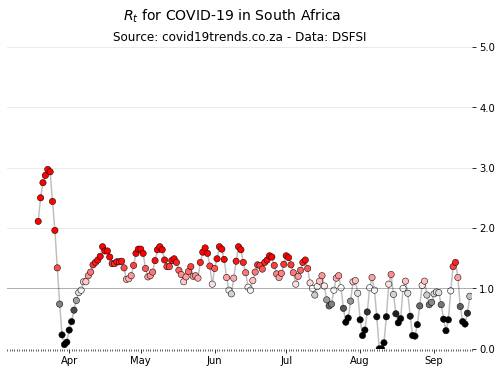

In [115]:
country = states_all_rt_i.filter(like='Total RSA', axis=0)
fig_country, ax = plt.subplots(figsize=(600/72,400/72))
ax = plot_rt(country, ax, state_name = '')
ax.set_title(credit, size=12, weight='light')
fig_country.suptitle(f'$R_t$ for COVID-19 in South Africa', size=14)

In [116]:
states_rt_i = states_all_rt_i.loc[state_filter]

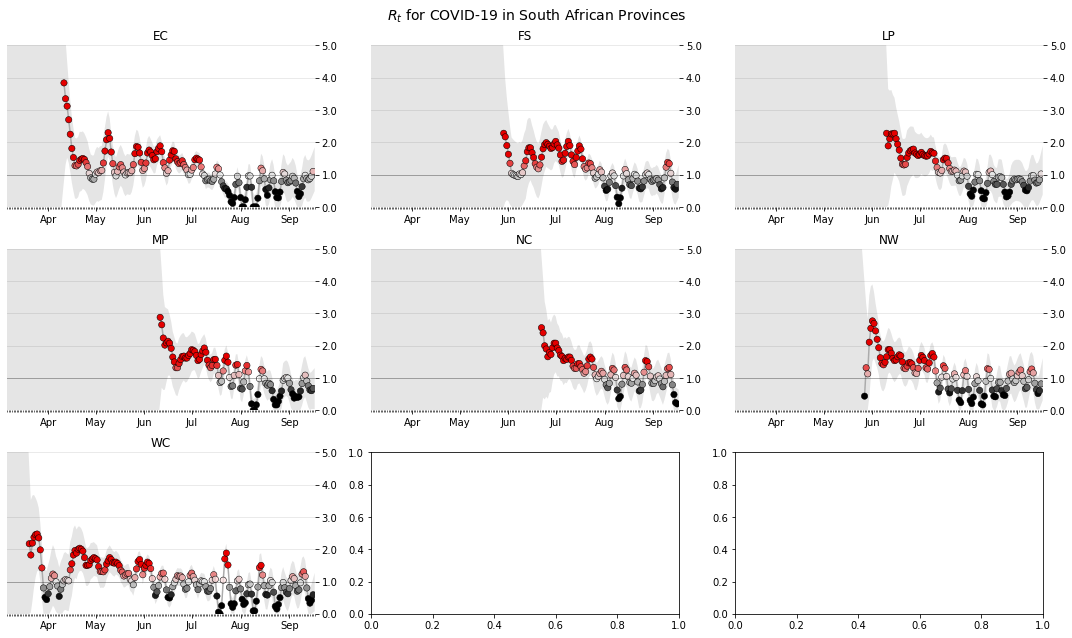

In [117]:
def all_plot(final_results):
    state_groups = final_results.groupby('state')
    
    ncols = 3
    nrows = int(np.ceil(len(state_groups) / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

    for i, (state_name, result) in enumerate(state_groups):
        axes.flat[i] = plot_rt(result, axes.flat[i], state_name)

    fig.tight_layout()
    fig.set_facecolor('w')
    
    fig.suptitle(f'$R_t$ for COVID-19 in South African Provinces', size=14)
    fig.subplots_adjust(top=0.92)
    
all_plot(states_rt_i)

## Standings plots

In [118]:
# ZA: South Arica lockdown level data as of 2020/05/03
no_lockdown = [

]
partial_lockdown = [

]
# add items as required -> 'Western Cape','WC',

FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

In [119]:
# ZA: df slighty different to US
mr = states_all_rt_i.groupby(level=0)[['ML', 'High_90', 'Low_90']].last()
mr

ML  High_90  Low_90
state                           
EC         1.10     1.72    0.38
FS         0.70     1.13    0.18
LP         1.02     1.69    0.25
MP         0.68     1.25    0.04
NC         0.20     0.68    0.00
NW         0.82     1.38    0.18
Total RSA  0.87     0.00    0.00
WC         0.59     1.09    0.04

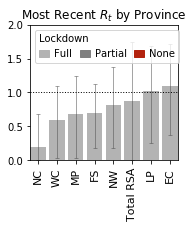

In [120]:
def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by Province'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    for bar, state_name in zip(bars, mr.index):
        if state_name in no_lockdown:
            bar.set_color(NONE_COLOR)
        if state_name in partial_lockdown:
            bar.set_color(PARTIAL_COLOR)

    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    leg = ax.legend(handles=[
                        Patch(label='Full', color=FULL_COLOR),
                        Patch(label='Partial', color=PARTIAL_COLOR),
                        Patch(label='None', color=NONE_COLOR)
                    ],
                    title='Lockdown',
                    ncol=3,
                    loc='upper left',
                    columnspacing=.75,
                    handletextpad=.5,
                    handlelength=1)

    leg._legend_box.align = "left"
    fig.set_facecolor('w')
    return fig, ax

mr.sort_values('ML', inplace=True)
plot_standings(mr);

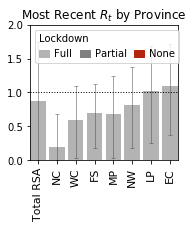

In [121]:
mr.sort_values('High_90', inplace=True)
plot_standings(mr);

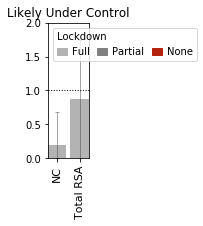

In [122]:
show = mr[mr.High_90.le(1)].sort_values('ML')
fig, ax = plot_standings(show, title='Likely Under Control');

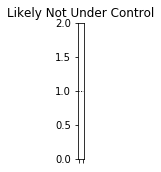

In [123]:
show = mr[mr.Low_90.ge(1.0)].sort_values('Low_90')
fig, ax = plot_standings(show, title='Likely Not Under Control');
ax.get_legend().remove()